# Artificial Neural Networks for Regression

_By: Ling Li Ya, Liana_

## Pre-training Preparation

### Installing Dependencies

In [1]:
!pip install tensorflow
!pip install keras

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

2021-11-26 12:06:33.285102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-26 12:06:33.285192: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Loading Data

In [3]:
# Cleaned dataset with no outliers
X_train_no = pd.read_csv('../dataset/no_outliers/X_train.csv')
X_test_no = pd.read_csv('../dataset/no_outliers/X_test.csv')
y_train_no = pd.read_csv('../dataset/no_outliers/y_train.csv')
y_test_no = pd.read_csv('../dataset/no_outliers/y_test.csv')

# Uncleaned original data
X_train_with = pd.read_csv('../dataset/with_outliers/X_train.csv')
X_test_with = pd.read_csv('../dataset/with_outliers/X_test.csv')
y_train_with = pd.read_csv('../dataset/with_outliers/y_train.csv')
y_test_with = pd.read_csv('../dataset/with_outliers/y_test.csv')

In [4]:
def standardise_data(X_train, y_train, X_test, y_test):
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Scale data to standardise data values
    X_train_trans = X_scaler.fit_transform(X_train)
    y_train_trans = y_scaler.fit_transform(y_train)
    X_test_trans = X_scaler.transform(X_test)
    y_test_trans = y_scaler.transform(y_test)
    
    print(X_train_trans.shape, y_train_trans.shape, X_test_trans.shape, y_test_trans.shape)

    return X_scaler, y_scaler, X_train_trans, y_train_trans, X_test_trans, y_test_trans

X_scaler_no, y_scaler_no, X_train_no_trans, y_train_no_trans, X_test_no_trans, y_test_no_trans = standardise_data(X_train_no, y_train_no, X_test_no, y_test_no)

(578, 9) (578, 1) (145, 9) (145, 1)


## Training

Using a layer with 5 neurons, with 9 input dimensions of normal weight, using relu activation function. Batch size is 20 and training epochs are 50.

In [5]:
def create_seq_model():
    model = Sequential()

    # Defining the input layer and first hidden layer
    model.add(Dense(units=5, input_dim=9, kernel_initializer='normal', activation='relu'))

    # Defining the second layer of the model
    model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

    # The output neuron is a single fully connected node as only a single number is predicted
    model.add(Dense(1, kernel_initializer='normal'))

    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

def train_model(model, X_train, y_train):
    # Fitting the ANN to the training data
    model.fit(X_train, y_train, batch_size=20, epochs=50, verbose=1)

    return model

model_no = create_seq_model()
model_no = train_model(model_no, X_train_no_trans, y_train_no_trans)

2021-11-26 12:06:38.235637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-26 12:06:38.235726: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-26 12:06:38.235757: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Liana-ASUS): /proc/driver/nvidia/version does not exist
2021-11-26 12:06:38.236244: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
29/29 [==============================] - 1s 2ms/step - loss: 0.9988
Epoch 2/50
29/29 [==============================] - 0s 4ms/step - loss: 0.9886
Epoch 3/50
29/29 [==============================] - 0s 5ms/step - loss: 0.9395
Epoch 4/50
29/29 [==============================] - 0s 4ms/step - loss: 0.8180
Epoch 5/50
29/29 [==============================] - 0s 5ms/step - loss: 0.6274
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.4467
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.3241
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2573
Epoch 9/50
29/29 [==============================] - 0s 3ms/step - loss: 0.2267
Epoch 10/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2098
Epoch 11/50
29/29 [==============================] - 0s 3ms/step - loss: 0.1996
Epoch 12/50
29/29 [==============================] - 0s 3ms/step - loss: 0.1936
Epoch 13/50
29/29 [==============================

## Hyperparameter Tuning

To find the best accuracy with the minimum number of layers/neurons.

### Grid Search

MAPE is used. MAPE is Mean Absolute Percent Error. This is defined as the Average Absolute Error divided by the Average of the Actual Quantity. A more elegant way to compute this would be to divide the Sum of the Absolute Error by the Sum of the Actual Quantity.

MAPE = (Sum of Abs. Error) / (Sum of Actuals)

In [6]:
# Find the best parameters for ANN
def find_best_params(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list = [5, 10, 15, 20]
    epoch_list = [5, 10, 50, 100]

    results = pd.DataFrame(columns=['trial_num', 'param', 'accuracy'])
    
    # Initialising the trials
    trial_number = 0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            trial_number += 1
            # Create ANN model
            model = Sequential()

            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # Output neuron
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)

            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # Printing the results of the current iteration
            print(trial_number, 'Parameters:','batch_size:', batch_size_trial,'-', 'Epochs:',epochs_trial, 'Accuracy:', 100 - MAPE)
            
            results = results.append(pd.DataFrame(data=[[trial_number, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]], columns=['trial_num', 'param', 'accuracy'] ))

    return(results)

results_no = find_best_params(X_train_no_trans, y_train_no_trans, X_test_no_trans, y_test_no_trans)

1 Parameters: batch_size: 5 - Epochs: 5 Accuracy: 78.75279204672135
2 Parameters: batch_size: 5 - Epochs: 10 Accuracy: 102.5975166805799
3 Parameters: batch_size: 5 - Epochs: 50 Accuracy: 88.87305648826376
4 Parameters: batch_size: 5 - Epochs: 100 Accuracy: 77.43303113520837
5 Parameters: batch_size: 10 - Epochs: 5 Accuracy: 145.13959171680335
6 Parameters: batch_size: 10 - Epochs: 10 Accuracy: 139.36259777098945
7 Parameters: batch_size: 10 - Epochs: 50 Accuracy: 81.49941744583646
8 Parameters: batch_size: 10 - Epochs: 100 Accuracy: 87.33536491038927
9 Parameters: batch_size: 15 - Epochs: 5 Accuracy: 127.55265445721002
10 Parameters: batch_size: 15 - Epochs: 10 Accuracy: 117.2652658123902
11 Parameters: batch_size: 15 - Epochs: 50 Accuracy: 60.66067935312461
12 Parameters: batch_size: 15 - Epochs: 100 Accuracy: 25.738124683843665
13 Parameters: batch_size: 20 - Epochs: 5 Accuracy: 97.37661524229348
14 Parameters: batch_size: 20 - Epochs: 10 Accuracy: 148.48608045964536
15 Parameters: 

### Plotting Results

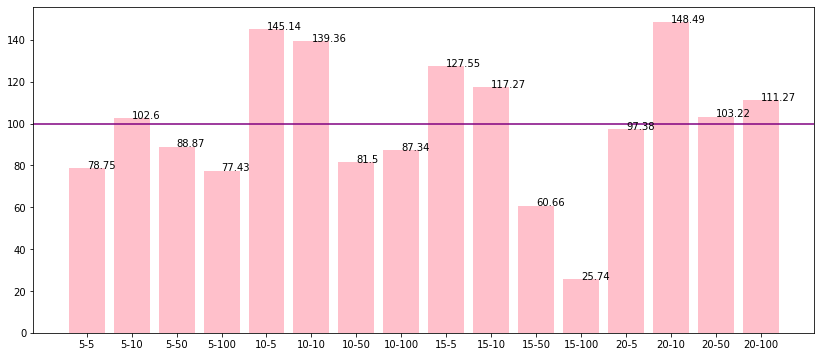

In [7]:
def plot_bar_chart(results):
    plt.figure(figsize=(14,6))
    plt.bar(results['param'], height=results['accuracy'], color='pink')
    plt.axhline(y=100, color='purple', linestyle='-')
    for a, b in zip([x for x in range(len(results['accuracy']))], round(results['accuracy'], 2)):
        plt.text(a, b, str(b), color='black')
    plt.show()

plot_bar_chart(results_no)

From the graph above, it can be known that the best hyperparameters are `batch_size` = 20 and `epochs` = 10.

In [8]:
# Fine-tune hyperparameters
def fine_tune_model(model, batch_size, epochs, X_scaler, y_scaler, X_train_trans, y_train_trans, X_test_trans, y_test_trans, columns):
    model.fit(X_train_trans, y_train_trans, batch_size=batch_size, epochs=epochs, verbose=0)

    pred = model.predict(X_test_trans)

    # Scale predictions
    pred = y_scaler.inverse_transform(pred)

    # Scale back to original
    y_test = y_scaler.inverse_transform(y_test_trans)
    X_test = X_scaler.inverse_transform(X_test_trans)

    test_data = pd.DataFrame(data=X_test, columns=columns)
    test_data['count'] = y_test
    test_data['pred_count'] = pred
    print(test_data.head())

    return test_data

test_data_no = fine_tune_model(
        model=model_no,
        batch_size=20,
        epochs=10,
        X_scaler=X_scaler_no,
        y_scaler=y_scaler_no,
        X_train_trans=X_train_no_trans,
        y_train_trans=y_train_no_trans,
        X_test_trans=X_test_no_trans,
        y_test_trans=y_test_no_trans,
        columns=X_test_no.columns
    )

   season  year  month  holiday  weekday  weather  temperature  humidity  \
0     3.0   1.0    7.0      0.0      0.0      1.0     0.721667  0.623750   
1     2.0   1.0    5.0      0.0      4.0      1.0     0.593333  0.520000   
2     3.0   1.0    8.0      0.0      5.0      2.0     0.765833  0.642500   
3     2.0   1.0    4.0      0.0      5.0      1.0     0.403333  0.377083   
4     4.0   1.0   11.0      0.0      1.0      1.0     0.319167  0.494167   

   windspeed   count   pred_count  
0   0.170396  6597.0  6846.541016  
1   0.229475  7384.0  6958.393066  
2   0.215792  7175.0  6984.139648  
3   0.300388  6460.0  5668.041016  
4   0.236325  5259.0  5018.238281  


In [9]:
def evaluate_model(test_data):
# Mean Absolute Percentage Error
    APE = 100 * (abs(test_data['count'] - test_data['pred_count']) / test_data['count'])
    test_data['APE'] = APE

    print("Accuracy: ", 100 - np.mean(APE))
    print(test_data.head())

evaluate_model(test_data_no)

Accuracy:  82.92475018593518
   season  year  month  holiday  weekday  weather  temperature  humidity  \
0     3.0   1.0    7.0      0.0      0.0      1.0     0.721667  0.623750   
1     2.0   1.0    5.0      0.0      4.0      1.0     0.593333  0.520000   
2     3.0   1.0    8.0      0.0      5.0      2.0     0.765833  0.642500   
3     2.0   1.0    4.0      0.0      5.0      1.0     0.403333  0.377083   
4     4.0   1.0   11.0      0.0      1.0      1.0     0.319167  0.494167   

   windspeed   count   pred_count        APE  
0   0.170396  6597.0  6846.541016   3.782644  
1   0.229475  7384.0  6958.393066   5.763908  
2   0.215792  7175.0  6984.139648   2.660075  
3   0.300388  6460.0  5668.041016  12.259427  
4   0.236325  5259.0  5018.238281   4.578089  


In [10]:
model_no.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 50        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


## Using Data With Outliers

In [11]:
X_scaler_with, y_scaler_with, X_train_with_trans, y_train_with_trans, X_test_with_trans, y_test_with_trans = standardise_data(X_train_with, y_train_with, X_test_with, y_test_with)

(584, 9) (584, 1) (147, 9) (147, 1)


In [12]:
model_with = create_seq_model()
model_with = train_model(model_with, X_train_with_trans, y_train_with_trans)

Epoch 1/50
30/30 [==============================] - 1s 3ms/step - loss: 0.9992
Epoch 2/50
30/30 [==============================] - 0s 2ms/step - loss: 0.9909
Epoch 3/50
30/30 [==============================] - 0s 5ms/step - loss: 0.9547
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.8443
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6600
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.4754
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 0.3426
Epoch 8/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2643
Epoch 9/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2262
Epoch 10/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2081
Epoch 11/50
30/30 [==============================] - 0s 2ms/step - loss: 0.1958
Epoch 12/50
30/30 [==============================] - 0s 2ms/step - loss: 0.1873
Epoch 13/50
30/30 [==============================

The same `batch_size` and `epochs` are used for accuracy comparison.

In [13]:
test_data_with = fine_tune_model(
    model=model_with,
    batch_size=20,
    epochs=10,
    X_scaler=X_scaler_with,
    y_scaler=y_scaler_with,
    X_train_trans=X_train_with_trans,
    y_train_trans=y_train_with_trans,
    X_test_trans=X_test_with_trans,
    y_test_trans=y_test_with_trans,
    columns=X_test_with.columns,
)

   season  year  month       holiday  weekday  weather  temperature  humidity  \
0     3.0   0.0    7.0 -3.469447e-18      6.0      1.0     0.686667  0.585000   
1     3.0   0.0    7.0 -3.469447e-18      4.0      1.0     0.750000  0.651250   
2     1.0   0.0    1.0 -3.469447e-18      6.0      2.0     0.233333  0.498750   
3     1.0   0.0    2.0 -3.469447e-18      2.0      2.0     0.192174  0.829565   
4     1.0   1.0    1.0 -3.469447e-18      4.0      2.0     0.341667  0.769583   

   windspeed   count   pred_count  
0   0.208342  5923.0  4890.563477  
1   0.159200  4592.0  4753.515137  
2   0.157963  1248.0  1691.410767  
3   0.053213  1360.0  1217.915894  
4   0.073396  4075.0  3919.364258  


In [14]:
evaluate_model(test_data=test_data_with)

Accuracy:  79.89955950538436
   season  year  month       holiday  weekday  weather  temperature  humidity  \
0     3.0   0.0    7.0 -3.469447e-18      6.0      1.0     0.686667  0.585000   
1     3.0   0.0    7.0 -3.469447e-18      4.0      1.0     0.750000  0.651250   
2     1.0   0.0    1.0 -3.469447e-18      6.0      2.0     0.233333  0.498750   
3     1.0   0.0    2.0 -3.469447e-18      2.0      2.0     0.192174  0.829565   
4     1.0   1.0    1.0 -3.469447e-18      4.0      2.0     0.341667  0.769583   

   windspeed   count   pred_count        APE  
0   0.208342  5923.0  4890.563477  17.430973  
1   0.159200  4592.0  4753.515137   3.517316  
2   0.157963  1248.0  1691.410767  35.529709  
3   0.053213  1360.0  1217.915894  10.447361  
4   0.073396  4075.0  3919.364258   3.819282  


In [15]:
model_with.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 5)                 50        
                                                                 
 dense_52 (Dense)            (None, 5)                 30        
                                                                 
 dense_53 (Dense)            (None, 1)                 6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


In conclusion, using cleaned data without outliers would give a higher accuracy than using data with outliers.